**LOAD THE DATASET FROM KAGGLE AND UNZIP IT **

In [ ]:
import os
import json

# Replace these with YOUR details
kaggle_username = "saubhagyajijaiswal"
kaggle_key = "KGAT_ae29da929b10f09e1e699bca978e2401"

# Create kaggle directory
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

# Write kaggle.json
kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
with open(kaggle_json_path, "w") as f:
    json.dump(
        {
            "username": kaggle_username,
            "key": kaggle_key
        },
        f
    )

# Set correct permissions (important)
os.chmod(kaggle_json_path, 0o600)

print("kaggle.json created at:", kaggle_json_path)
!kaggle datasets list -s "plant village"
!kaggle datasets download -d asheniranga/leaf-disease-dataset-combination
!unzip leaf-disease-dataset-combination.zip



**IMPORTING THE NECESSARY LIBRARIES**

In [2]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16


**IMPORTING THE VGG16 CNN MODEL AND USING ITS BASE MODEL ONLY**

In [3]:
conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**SETTING UP THE TRAINABLE AND NON TRAINABLE PARAMETERS FOR FINE TUNING**

In [5]:
conv_base.trainable=True
set_trainable=False
for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

for layer in conv_base.layers:
    print(layer.name,layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


**LOADING THE TRAIN AND TEST DATASET**

In [6]:
from keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    directory=r"image data/train/apple",
    labels='inferred',
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

test_ds = image_dataset_from_directory(
    directory="image data/train/apple",
    labels='inferred',
    seed=42,
    image_size=(224, 224),
    batch_size=32
)
validation_ds = image_dataset_from_directory(
    directory="image data/validation/apple",
    labels='inferred',
    seed=42,
    image_size=(224, 224),
    batch_size=32
)


Found 2286 files belonging to 4 classes.
Found 2286 files belonging to 4 classes.
Found 569 files belonging to 4 classes.


**ADDING THE FULLY CONNECTED LAYER AND OUTPUT LAYER TO THE BASE**

In [7]:
model=Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(4,activation='softmax'))

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 13,503,236 (51.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [9]:
train_class_names = train_ds.class_names
print(train_class_names)

['apple scab', 'black rot', 'cedar apple rust', 'healthy']


**NORMALIZE THE PIXELS**

In [10]:
def process(image,label):
    image=tensorflow.cast(image/255,tensorflow.float32)
    return image,label

train_ds=train_ds.map(process)
validation_ds=validation_ds.map(process)
test_ds=test_ds.map(process)

In [12]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

**TRAINING THE MODEL**

In [13]:
history=model.fit(train_ds,epochs=10,validation_data=test_ds)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 442ms/step - accuracy: 0.6809 - loss: 0.8383 - val_accuracy: 0.8863 - val_loss: 0.2563
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 324ms/step - accuracy: 0.9425 - loss: 0.1834 - val_accuracy: 0.9895 - val_loss: 0.0623
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 335ms/step - accuracy: 0.9806 - loss: 0.0781 - val_accuracy: 0.9834 - val_loss: 0.0694
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 339ms/step - accuracy: 0.9822 - loss: 0.0540 - val_accuracy: 0.9856 - val_loss: 0.0462
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 333ms/step - accuracy: 0.9871 - loss: 0.0409 - val_accuracy: 0.9974 - val_loss: 0.0194
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 334ms/step - accuracy: 0.9975 - loss: 0.0142 - val_accuracy: 0.9904 - val_loss: 0.0340
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 338ms/step - accuracy: 0.9956 - loss: 0.0152 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 338ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accu

**PREDICTION VERIFICATION**

In [15]:
import tensorflow as tf
import numpy as np
from keras.utils import load_img, img_to_array

# Path to image
img_path = "/content/image data/validation/apple/cedar apple rust/0340baaa-e9cc-4c04-8f9b-c204180d9ae3___FREC_C.Rust 3805.JPG"

# Same size used in training
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = img_array / 255.0           # normalize
img_array = np.expand_dims(img_array, axis=0)  # (1,224,224,3)

# Predict
pred = model.predict(img_array)

# Get class index
pred_class = np.argmax(pred, axis=1)[0]

# Get class name
# Use the stored train_class_names
print("Predicted class:", train_class_names[pred_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted class: cedar apple rust


**ACCURACY PLOTING**

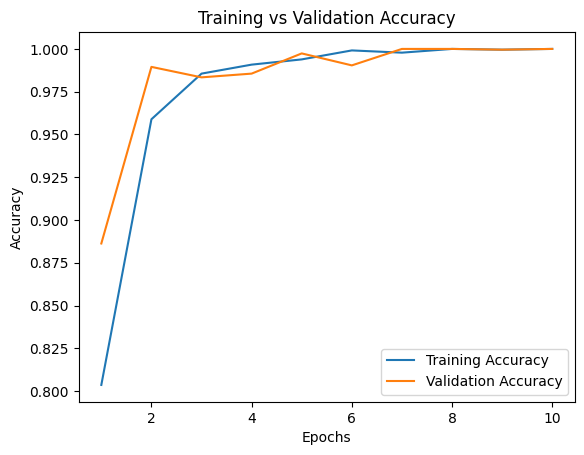

In [16]:
import matplotlib.pyplot as plt

# Accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Epochs
epochs = range(1, len(train_acc) + 1)

# Plot
plt.figure()
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()
